In [1]:
import pandas as pd
from pathlib import Path 
from tqdm import tqdm

In [2]:
# !wget https://figshare.com/ndownloader/files/7038038 -O ../data/aggression/original/wikidetox_aggression_texts.tsv
# !wget https://figshare.com/ndownloader/files/7394506 -O ../data/aggression/original/wikidetox_aggression_annotations.tsv

In [3]:
datadir = Path("../data/aggression")
original_dir = datadir / "original"
train_path = datadir / "train.csv"
val_path = datadir / "val.csv"
test_path = datadir / "test.csv"

original_texts = pd.read_csv(original_dir / "wikidetox_aggression_texts.tsv", delimiter="\t")
original_annotations = pd.read_csv(original_dir / "wikidetox_aggression_annotations.tsv", delimiter="\t")

In [4]:
original_texts.shape, original_annotations.shape

((115864, 7), (1365217, 4))

In [5]:
original_texts.columns, original_annotations.columns

(Index(['rev_id', 'comment', 'year', 'logged_in', 'ns', 'sample', 'split'], dtype='object'),
 Index(['rev_id', 'worker_id', 'aggression', 'aggression_score'], dtype='object'))

In [6]:
original_texts["split"].unique()

array(['train', 'dev', 'test'], dtype=object)

In [7]:
full_df = pd.merge(original_texts, original_annotations, how="inner", on="rev_id")
full_df['comment'] = full_df['comment'].str.replace('NEWLINE_TOKEN', '')
full_df['comment'] = full_df['comment'].str.replace('==', '')
full_df = full_df.drop_duplicates()
full_df.shape, full_df.columns

((1365217, 10),
 Index(['rev_id', 'comment', 'year', 'logged_in', 'ns', 'sample', 'split',
        'worker_id', 'aggression', 'aggression_score'],
       dtype='object'))

In [8]:
raw_train = full_df[full_df["split"] == "train"]
raw_val = full_df[full_df["split"] == "dev"]
raw_test = full_df[full_df["split"] == "test"]
raw_train.shape, raw_val.shape, raw_test.shape

((762046, 10), (253589, 10), (349582, 10))

In [9]:
raw_train.head()

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,aggression,aggression_score
0,37675,`-This is not ``creative``. Those are the dic...,2002,True,article,random,train,1362,1.0,-1.0
1,37675,`-This is not ``creative``. Those are the dic...,2002,True,article,random,train,2408,0.0,1.0
2,37675,`-This is not ``creative``. Those are the dic...,2002,True,article,random,train,1493,0.0,0.0
3,37675,`-This is not ``creative``. Those are the dic...,2002,True,article,random,train,1439,0.0,0.0
4,37675,`-This is not ``creative``. Those are the dic...,2002,True,article,random,train,170,0.0,0.0


In [10]:
def check_users(train, test, dev):
    train_users = train["worker_id"].unique()
    dev_users = dev["worker_id"].unique()
    test_users = test["worker_id"].unique()
    print("sizes -", "train:", train_users.shape, "val:", dev_users.shape, "test:", test_users.shape)
    train_dev = (len(set(train_users) - set(dev_users)), len(set(dev_users) - set(train_users)))
    train_test = (len(set(train_users) - set(test_users)), len(set(test_users) - set(train_users)))
    test_dev = (len(set(test_users) - set(dev_users)), len(set(dev_users) - set(test_users)))
    print(train_dev, train_test, test_dev)
    print(set(train_users) - set(test_users))

In [11]:
def clean_users(new_train, new_val, new_test):
    in_test = new_train[new_train["worker_id"].isin(new_test["worker_id"])]
    in_both = in_test[in_test["worker_id"].isin(new_val["worker_id"])]
    dev_both = new_val[new_val["worker_id"].isin(in_both["worker_id"])]
    test_both = new_test[new_test["worker_id"].isin(in_both["worker_id"])]
    print(in_both.shape, dev_both.shape, test_both.shape)
    return in_both, dev_both, test_both

In [12]:
def average_annotation_per_user(df, crop=False):
    annotation_number = df.groupby(by=["worker_id"]).count()["comment"].sort_values()
    print("annotator head")
    print(annotation_number.head())
    print("annotator tail")
    print(annotation_number.tail())
    mean = annotation_number.mean()
    max = annotation_number.max()
    min = annotation_number.min()
    median = annotation_number.median()
    (annotation_number/max).reset_index()["comment"].plot()
    all = df.shape[0]
    upper_threshold = 0.8*max
    lower_threshold = 0.05*max
    print("ANNOTATORS")
    print("min:", min, "mean:", mean, "median:", median ,"max:", max, "all:", all)
    text_number = df.groupby(by=["comment"]).count()["worker_id"].sort_values()
    # print("text head")
    # print(text_number.head())
    # print("text tail")
    # print(text_number.tail())
    mean = text_number.mean()
    max = text_number.max()
    min = text_number.min()
    median = text_number.median()
    # (text_number/max).reset_index()["worker_id"].plot()
    all = df.shape[0]
    print("TEXTS")
    print("min:", min, "mean:", mean, "median:", median ,"max:", max, "all:", all)    
    curr_df = df
    if crop:
        print("cropping...")
        print(curr_df.shape)
        to_crop = []
        for worker in tqdm(df["worker_id"].unique()):
            if annotation_number[worker] < lower_threshold:
                curr_df = curr_df[curr_df["worker_id"] != worker]
            if annotation_number[worker] > upper_threshold:
                to_crop.append(worker)
        print("after lower crop, before upper")
        print(curr_df.shape)
        for worker in tqdm(to_crop):
            crop_number = int(annotation_number[worker] - upper_threshold)
            ann_to_drop = curr_df[curr_df["worker_id"] == worker].sample(n=crop_number)
            anns = pd.merge(curr_df, ann_to_drop, how="outer", indicator=True)
            curr_df = anns[anns["_merge"] == "left_only"].drop(columns=["_merge"], axis=1)
        print("cropping finished...")
        print(curr_df.shape)
    return curr_df.dropna()

In [13]:
def change_id_to_int(df):
    df["worker_id"] = df["worker_id"].astype(int)
    return df

In [14]:
def analyze_annotations(train, dev, test, crop=False):
    print('-'*10, 'check', "-"*10)
    check_users(train, test, dev)
    print('-'*10, 'clean', "-"*10)
    in_both, dev_both, test_both = clean_users(train, dev, test)
    print('-'*10, 'train', "-"*10)
    crop_train = average_annotation_per_user(in_both, crop=crop)
    print('-'*10, 'dev', "-"*10)
    crop_dev = average_annotation_per_user(dev_both, crop=crop)
    print('-'*10, 'test', "-"*10)
    crop_test = average_annotation_per_user(test_both, crop=crop)
    print('-'*10, 'check 2', "-"*10)
    check_users(crop_train, crop_test, crop_dev)
    print('-'*10, 'clean 2', "-"*10)
    train_final, dev_final, test_final = clean_users(crop_train, crop_dev, crop_test)
    print('-'*10, 'check 3', "-"*10)
    check_users(train_final, test_final, dev_final)
    train_final = change_id_to_int(train_final)
    dev_final = change_id_to_int(dev_final)
    test_final = change_id_to_int(test_final)
    return train_final, dev_final, test_final

---------- check ----------
sizes - train: (4048,) val: (4018,) test: (4039,)
(32, 2) (13, 4) (33, 12)
{3425, 4033, 3971, 3812, 3942, 3975, 3977, 3852, 4044, 3886, 4047, 3828, 3295}
---------- clean ----------
(761766, 10) (253551, 10) (349353, 10)
---------- train ----------
annotator head
worker_id
3751    1
3858    1
3098    1
3936    1
3357    1
Name: comment, dtype: int64
annotator tail
worker_id
381    719
344    733
70     733
62     734
11     750
Name: comment, dtype: int64
ANNOTATORS
min: 1 mean: 190.20374531835205 median: 146.0 max: 750 all: 761766
TEXTS
min: 7 mean: 10.973134930352487 median: 10.0 max: 57 all: 761766
cropping...
(761766, 10)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4005/4005 [00:27<00:00, 147.65it/s]


after lower crop, before upper
(750814, 10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:49<00:00,  1.46it/s]


cropping finished...
(746878, 10)
---------- dev ----------
annotator head
worker_id
2867    1
2783    1
3098    1
3989    1
3986    1
Name: comment, dtype: int64
annotator tail
worker_id
270    247
303    248
168    248
115    249
11     269
Name: comment, dtype: int64
ANNOTATORS
min: 1 mean: 63.308614232209734 median: 47.0 max: 269 all: 253551
TEXTS
min: 7 mean: 10.95441977015467 median: 10.0 max: 47 all: 253551
cropping...
(253551, 10)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4005/4005 [00:11<00:00, 361.41it/s]


after lower crop, before upper
(248936, 10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.72it/s]


cropping finished...
(248437, 10)
---------- test ----------
annotator head
worker_id
2556    1
3995    1
1857    1
1178    1
3239    1
Name: comment, dtype: int64
annotator tail
worker_id
381    448
518    454
11     456
62     461
328    467
Name: comment, dtype: int64
ANNOTATORS
min: 1 mean: 87.22921348314607 median: 54.0 max: 467 all: 349353
TEXTS
min: 7 mean: 15.088886969291236 median: 10.0 max: 58 all: 349353
cropping...
(349353, 10)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4005/4005 [00:20<00:00, 199.33it/s]


after lower crop, before upper
(337491, 10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.65it/s]


cropping finished...
(335993, 10)
---------- check 2 ----------
sizes - train: (3450,) val: (3355,) test: (3093,)
(144, 49) (527, 170) (212, 474)
{2048, 2062, 2067, 2091, 2094, 2096, 2122, 2144, 2206, 2212, 2225, 2226, 182, 2239, 2240, 2245, 199, 2247, 233, 2283, 267, 2332, 298, 2376, 2380, 2386, 2389, 2394, 2395, 2400, 2438, 2442, 2444, 2454, 2458, 2464, 2465, 2472, 2477, 2483, 2491, 2503, 2526, 2560, 2570, 2573, 2574, 2590, 2602, 2606, 2618, 2621, 2637, 2642, 2650, 2656, 2658, 2665, 2691, 2703, 2706, 2708, 2719, 2733, 2740, 2744, 2747, 2754, 2759, 2765, 2768, 2803, 2808, 2810, 2811, 2812, 2816, 2820, 2828, 2830, 2833, 2837, 2839, 2842, 2844, 2847, 2850, 2854, 2855, 2857, 2858, 2859, 2861, 2866, 2868, 2870, 2891, 2892, 2893, 2915, 2920, 2927, 2933, 2936, 2941, 2947, 2954, 2963, 2964, 2966, 2969, 2971, 2972, 2973, 2974, 2979, 2980, 2982, 2990, 948, 2996, 2997, 3001, 3002, 3008, 3011, 3018, 3019, 3020, 3022, 3023, 3026, 980, 3035, 3038, 3040, 998, 999, 1000, 3047, 3050, 3054, 3055, 3056

/tmp/ipykernel_2610012/3110118588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["worker_id"] = df["worker_id"].astype(int)
/tmp/ipykernel_2610012/3110118588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["worker_id"] = df["worker_id"].astype(int)


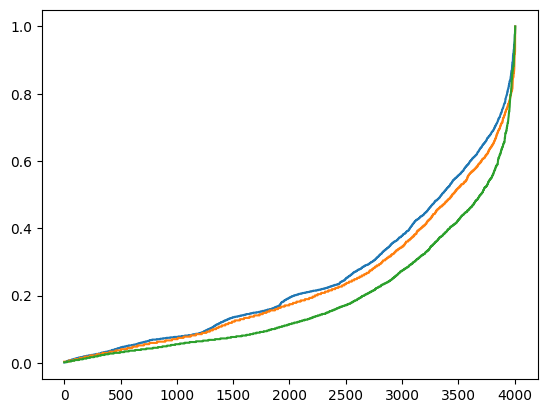

In [15]:
train_final, dev_final, test_final = analyze_annotations(raw_train, raw_val, raw_test, crop=True)

---------- check ----------
sizes - train: (2856,) val: (2856,) test: (2856,)
(0, 0) (0, 0) (0, 0)
set()
---------- clean ----------
(711584, 10) (238062, 10) (325339, 10)
---------- train ----------
annotator head
worker_id
1384    38
2345    38
2207    38
2194    38
2189    38
Name: comment, dtype: int64
annotator tail
worker_id
328    600
344    600
81     600
70     600
68     600
Name: comment, dtype: int64
ANNOTATORS
min: 38 mean: 249.15406162464987 median: 203.0 max: 600 all: 711584
TEXTS
min: 3 mean: 10.250270091182783 median: 9.0 max: 54 all: 711584
---------- dev ----------
annotator head
worker_id
888     14
1428    14
1486    14
2352    14
3371    14
Name: comment, dtype: int64
annotator tail
worker_id
270     216
1127    216
261     216
217     216
51      216
Name: comment, dtype: int64
ANNOTATORS
min: 14 mean: 83.35504201680672 median: 67.0 max: 216 all: 238062
TEXTS
min: 3 mean: 10.285232869610299 median: 9.0 max: 45 all: 238062
---------- test ----------
annotator head

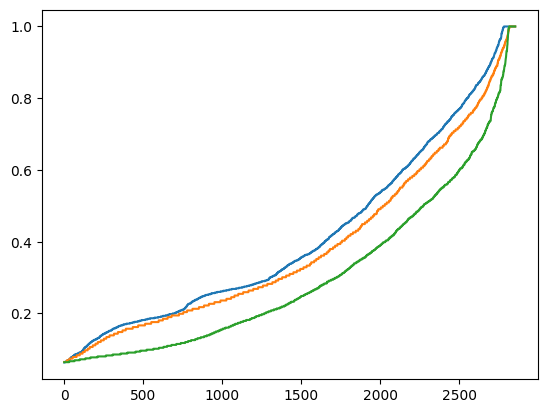

In [16]:
train_final, dev_final, test_final = analyze_annotations(train_final, dev_final, test_final, crop=False)

In [17]:
# train_final.to_csv(train_path, index=False)
# dev_final.to_csv(val_path, index=False)
# test_final.to_csv(test_path, index=False)